In [1]:
# Import modulses
import pandas as pd 
import numpy as np 
from bs4 import BeautifulSoup
import requests
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
# import dataset already downloaded in our local machine:
# This dataset is taken from kaggle database: "https://www.kaggle.com/datasets/hanzlanawaz/economy-of-europe-2022"
# To get economic indicator of european countries
europe = pd.read_csv("Economy_Indicators.csv")

# Drop the columns that we are not going to use for our project
europe_cleaned = europe.drop(europe.columns[[2,3,4,5,6,7,9]], axis=1)

In [3]:
url = ('https://www.finder.com/uk/world-cost-of-a-flat')
pd.read_html(url)
tables = pd.read_html(url)
df = tables[0]
merged_df1 = pd.merge(df,europe_cleaned)

In [4]:
## We are using cost living ranking as an indicator in our project, which we found in this website. 
## Where each indices are relative to the New York indices
# Which means, rent index of 120 represent that on an average in that city rents are 20% more
# expensive than in New York City. If a city has rent index of 70, that 
# means on average rent in that city is 30% less expensive than in New York City.

url = ('https://www.numbeo.com/cost-of-living/rankings_by_country.jsp?title=2023&region=150')
response = pd.read_html(url)
response

tables1 = response
df1 = tables1[1]

# Drop column which are not used in our project
df1_cleaned1 = df1.drop(df1.columns[[0]], axis=1)

# Merge two dataframe
europe_final_df = pd.merge(merged_df1,df1_cleaned1)


In [5]:
# This dataset we take from kaggle
data = pd.read_csv('data.csv')
data

data_cleaned = data.drop(data.columns[[0,2,3,5,6,7,8,9,10,11,12,13,17]], axis=1)

europe_final = europe_final_df.merge(data_cleaned, how = "left" , left_on = "Country", right_on = "country")
data_cleaned.head()

,pop2023,country,immigrants,percPop,emigrants
0,339996563.00,United States,50632836,15.28,2996223
1,83294633.00,Germany,15762457,18.81,3855268
2,36947025.00,Saudi Arabia,13454842,38.65,299268
3,144444359.00,Russia,11636911,7.97,10756697
4,67736802.00,United Kingdom,9359587,13.79,4732510


In [6]:
# get more data about traffic score index
# Traffic Index is a composite index of time consumed in traffic due to job commute, 
# estimation of time consumption dissatisfaction, CO2 consumption estimation in traffic
# and overall inefficiencies in the traffic system. Lower the index is better

# Read html content from website and transform in dataframe
table = pd.read_html("https://www.numbeo.com/traffic/rankings_by_country.jsp?title=2023&region=150")
transport_df = table[1]
# remove unused columns for this project from dataframe
transport_df = transport_df.drop(columns = {"Time Exp. Index", "Inefficiency Index", "Rank"})
# rename column name
transport_df = transport_df.rename(columns = {"Traffic Index": "traffic_index", "Time Index(in minutes)": "avg_time",  "CO2 Emission Index": "co2_emission"})

In [7]:
# get more data about country saety and security score by using same method as used before
# Crime Index is an estimation of overall level of crime in a given city or a country 
# lower the index lower the crime rate and vice versa
# Safety index is, on the other way, quite opposite of crime index. 
# If the city has a high safety index, it is considered very safe

table = pd.read_html("https://www.numbeo.com/crime/rankings_by_country.jsp?title=2023&region=150")
safety_df = pd.DataFrame(table[1])
safety_df = safety_df.drop(columns = "Rank")

In [8]:
# Merge two table crime and transport
transport_safety_df = transport_df.merge(safety_df, how = "left", on = "Country" )

In [9]:
# For nomad internet is most important aspects for daily life.
# To get internet speed across countries we use BeautifulSoup get data from speedtest.net
url = "https://www.speedtest.net/global-index#mobile"  # define the url
response = requests.get(url)   # request to the webpage using requests

# read the content using BeautifulSoup 
soup = BeautifulSoup(response.content)

# Extract content using targeted html tag and attributes
speed = soup.find_all("tr", attrs= {"class" : "data-result results"} )

# create dictionary later to transform in to dataframe
internet_speed = {}
for data in speed:
    rank =  data.find_all("td")[0].get_text().strip()
    country = data.find_all("td")[2].get_text().strip()
    value = data.find_all("td")[3].get_text().strip()
    internet_speed[rank] = country, value
    
# Change dictionary into dataframe
internet_df = pd.DataFrame(internet_speed).T

# rename the column to make more redable
internet_df = internet_df.rename(columns = {0: "state", 1: "internet-speed"})

# From internet_df separate capital city
internet_df["capital-city"] = internet_df["state"].str.split(",").str[0]
internet_df["Country"] = internet_df["state"].str.split(",").str[1]

# drop the state column
internet_df = internet_df.drop(["state"], axis = 1)

# internet-speed column is in type(object) form convert it in to float type
internet_df["internet-speed"] = internet_df["internet-speed"].astype(float)

# There are several city per country to get average speed for country group the city speed value by COuntry
internet_df = internet_df.groupby("Country").agg({"internet-speed": "mean"}).reset_index()

# Remove any empty string in country name
internet_df["Country"] = internet_df["Country"].str.strip()


# Merge the dataframe 
merged_df = transport_safety_df.merge(internet_df, how = "left", on = "Country")

# There are some NaN values in internet speed fill them with average speed. 
merged_df["internet-speed"] = merged_df["internet-speed"].fillna(merged_df["internet-speed"].mean())


In [10]:
# Drop more columns that are no
europe_final1 = europe_final.drop(europe_final.columns[[1,2,4,5,8,13,16]], axis=1)

In [11]:
europe_nomads = pd.merge(merged_df,europe_final1)

In [12]:
europe_nomads_final = europe_nomads.drop(europe_nomads.columns[[3,7]], axis=1)
europe_nomads_final.sort_values(["Crime Index", "Safety Index", "internet-speed", "Cost of Living Index"], ascending=[True, False, False, True ], inplace=True)
europe_nomads_final

,Country,traffic_index,avg_time,Crime Index,Safety Index,internet-speed,Cost of Living Index,Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,pop2023,immigrants,percPop
24,Switzerland,93.30,28.40,23.60,76.40,189.18,114.20,50.20,113.90,109.50,118.70,8796669.00,2491249,28.79
20,Slovenia,99.20,26.10,24.20,75.80,114.35,50.80,16.60,43.90,43.60,61.70,2119675.00,277964,13.37
23,Croatia,96.10,26.50,24.60,75.40,81.23,46.70,12.20,39.50,39.50,56.20,4008617.00,528056,12.86
29,Iceland,88.90,20.60,24.90,75.10,114.35,83.30,36.70,78.30,86.90,90.10,375318.00,65424,19.17
31,Estonia,84.00,23.80,25.10,74.90,114.35,54.80,16.40,42.40,55.10,61.40,1322765.00,199277,15.02
30,Denmark,87.50,28.50,26.60,73.40,213.12,78.60,30.40,62.40,91.90,105.00,5910913.00,717574,12.39
26,Czech Republic,90.60,29.50,26.60,73.40,114.35,48.90,19.10,40.70,36.60,71.80,10495295.00,540921,5.05
32,Finland,82.60,27.20,26.80,73.20,90.47,67.50,22.70,58.20,70.40,98.80,5545475.00,386052,6.97
28,Netherlands,89.40,25.50,27.30,72.70,108.03,68.60,33.40,57.40,67.60,107.80,17618299.00,2358333,13.76
33,Austria,79.10,24.80,27.30,72.70,105.55,66.00,23.10,58.00,63.50,91.20,8958960.00,1738183,19.30


In [13]:
import numpy as np

def negative_index(col):
    q40 = col.quantile(0.4)
    q60 = col.quantile(0.6)
    result = []
    for val in col:
        if val < q40:
            result.append("\U0001F41F \U0001F41F \U0001F41F")
        elif val >= q40 and val < q60:
            result.append("\U0001F420 \U0001F420")
        else: 
            result.append("\U0001F419")
    return result

def positive_index(col):
    q40 = col.quantile(0.4)
    q60 = col.quantile(0.6)
    mean_index = np.mean(col)
    result = []
    for val in col:
        if val >= q60:
            result.append("\U0001F41F \U0001F41F \U0001F41F")
        elif val >= q40 and val < q60:
            result.append("\U0001F420 \U0001F420")
        else: 
            result.append("\U0001F419")
    return result

# Define empty dataframe
rated_df = pd.DataFrame()

# Assign country in new dataframe from final dataframe
rated_df["Country"] = europe_nomads_final["Country"]

#Lower the index is better
rated_df["traffic"] = negative_index(europe_nomads_final["traffic_index"])

# cost of living the lower the best
rated_df["living"] = negative_index(europe_nomads_final["Cost of Living Index"])

# rent index the lower the better
rated_df["rent"] = negative_index(europe_nomads_final["Rent Index"])

# crime index : lower the better
rated_df["crime"] = negative_index(europe_nomads_final["Crime Index"])

# safety index: higher the better
rated_df["safety"] = positive_index(europe_nomads_final["Safety Index"])

# internet speed: higher the speed better
rated_df["internet"] = positive_index(europe_nomads_final["internet-speed"])

rated_df


,Country,traffic,living,rent,crime,safety,internet
24,Switzerland,🐟 🐟 🐟,🐙,🐙,🐟 🐟 🐟,🐟 🐟 🐟,🐟 🐟 🐟
20,Slovenia,🐟 🐟 🐟,🐠 🐠,🐟 🐟 🐟,🐟 🐟 🐟,🐟 🐟 🐟,🐟 🐟 🐟
23,Croatia,🐟 🐟 🐟,🐟 🐟 🐟,🐟 🐟 🐟,🐟 🐟 🐟,🐟 🐟 🐟,🐙
29,Iceland,🐟 🐟 🐟,🐙,🐙,🐟 🐟 🐟,🐟 🐟 🐟,🐟 🐟 🐟
31,Estonia,🐟 🐟 🐟,🐠 🐠,🐟 🐟 🐟,🐟 🐟 🐟,🐟 🐟 🐟,🐟 🐟 🐟
30,Denmark,🐟 🐟 🐟,🐙,🐙,🐟 🐟 🐟,🐟 🐟 🐟,🐟 🐟 🐟
26,Czech Republic,🐟 🐟 🐟,🐟 🐟 🐟,🐠 🐠,🐟 🐟 🐟,🐟 🐟 🐟,🐟 🐟 🐟
32,Finland,🐟 🐟 🐟,🐙,🐙,🐟 🐟 🐟,🐟 🐟 🐟,🐙
28,Netherlands,🐟 🐟 🐟,🐙,🐙,🐟 🐟 🐟,🐟 🐟 🐟,🐠 🐠
33,Austria,🐟 🐟 🐟,🐙,🐙,🐟 🐟 🐟,🐟 🐟 🐟,🐠 🐠


In [14]:
# calculate mean of all columns
means = europe_nomads_final.mean()

# Create a boolean mask for countries that have values higher than the mean in at least 3 columns
mask = (europe_nomads_final > means).sum(axis=1) >= 3

# Filter the DataFrame to only include countries with an internet score above the mean
result = europe_nomads_final[mask & (europe_nomads_final['internet-speed'] > means['internet-speed'])]

# Sort the resulting DataFrame by the internet score in descending order
result = result.sort_values(by='internet-speed', ascending=False)

# Print the resulting DataFrame
filtered = pd.DataFrame(result)

filtered_index = pd.DataFrame()

filtered_index["Country"] = filtered["Country"]


#Lower the index is better
filtered_index["traffic"] = negative_index(filtered["traffic_index"])

# cost of living the lower the best
filtered_index["living"] = negative_index(filtered["Cost of Living Index"])

# rent index the lower the better
filtered_index["rent"] = negative_index(filtered["Rent Index"])

# crime index : lower the better
filtered_index["crime"] = negative_index(filtered["Crime Index"])

# safety index: higher the better
filtered_index["safety"] = positive_index(filtered["Safety Index"])

# internet speed: higher the speed better
filtered_index["internet"] = positive_index(filtered["internet-speed"])

filtered_index

C:\Users\udaya\AppData\Local\Temp\ipykernel_19636\1685062873.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  means = europe_nomads_final.mean()
C:\Users\udaya\AppData\Local\Temp\ipykernel_19636\1685062873.py:5: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  mask = (europe_nomads_final > means).sum(axis=1) >= 3


,Country,traffic,living,rent,crime,safety,internet
30,Denmark,🐟 🐟 🐟,🐙,🐙,🐟 🐟 🐟,🐟 🐟 🐟,🐟 🐟 🐟
9,Romania,🐙,🐟 🐟 🐟,🐟 🐟 🐟,🐠 🐠,🐠 🐠,🐟 🐟 🐟
16,Spain,🐟 🐟 🐟,🐠 🐠,🐠 🐠,🐙,🐙,🐟 🐟 🐟
7,France,🐙,🐙,🐙,🐙,🐙,🐠 🐠
24,Switzerland,🐟 🐟 🐟,🐙,🐙,🐟 🐟 🐟,🐟 🐟 🐟,🐠 🐠
8,Hungary,🐙,🐟 🐟 🐟,🐟 🐟 🐟,🐙,🐙,🐙
10,Poland,🐠 🐠,🐟 🐟 🐟,🐟 🐟 🐟,🐟 🐟 🐟,🐟 🐟 🐟,🐙
12,Portugal,🐠 🐠,🐠 🐠,🐠 🐠,🐠 🐠,🐠 🐠,🐙


In [15]:
"""def negative(col):
    q40 = col.quantile(0.4)
    q60 = col.quantile(0.6)
    result = []
    for val in col:
        if val < q40:
            result.append("Above")
        elif val >= q40 and val < q60:
            result.append("In Between")
        else: 
            result.append("Below")
    return result

def positive(col):
    q40 = col.quantile(0.4)
    q60 = col.quantile(0.6)
    mean_index = np.mean(col)
    result = []
    for val in col:
        if val >= q60:
            result.append("Above")
        elif val >= q40 and val < q60:
            result.append("In Between")
        else: 
            result.append("Below")
    return result

# Define empty dataframe
rated_df_val = pd.DataFrame()

# Assign country in new dataframe from final dataframe
rated_df_val["Country"] = europe_nomads_final["Country"]

#Lower the index is better
rated_df_val["traffic"] = negative(europe_nomads_final["traffic_index"])

# cost of living the lower the best
rated_df_val["living"] = negative(europe_nomads_final["Cost of Living Index"])

# rent index the lower the better
rated_df_val["rent"] = negative(europe_nomads_final["Rent Index"])

# crime index : lower the better
rated_df_val["crime"] = negative(europe_nomads_final["Crime Index"])

# safety index: higher the better
rated_df_val["safety"] = positive(europe_nomads_final["Safety Index"])

# internet speed: higher the speed better
rated_df_val["internet"] = positive(europe_nomads_final["internet-speed"])

rated_df_val"""
# This is just a try to get something interesting but will see later when have time

'def negative(col):\n    q40 = col.quantile(0.4)\n    q60 = col.quantile(0.6)\n    result = []\n    for val in col:\n        if val < q40:\n            result.append("Above")\n        elif val >= q40 and val < q60:\n            result.append("In Between")\n        else: \n            result.append("Below")\n    return result\n\ndef positive(col):\n    q40 = col.quantile(0.4)\n    q60 = col.quantile(0.6)\n    mean_index = np.mean(col)\n    result = []\n    for val in col:\n        if val >= q60:\n            result.append("Above")\n        elif val >= q40 and val < q60:\n            result.append("In Between")\n        else: \n            result.append("Below")\n    return result\n\n# Define empty dataframe\nrated_df_val = pd.DataFrame()\n\n# Assign country in new dataframe from final dataframe\nrated_df_val["Country"] = europe_nomads_final["Country"]\n\n#Lower the index is better\nrated_df_val["traffic"] = negative(europe_nomads_final["traffic_index"])\n\n# cost of living the lower the

In [16]:
means = europe_nomads_final.mean()

# Create a boolean mask for countries that have values higher than the mean in at least 3 columns
mask = (europe_nomads_final > means).sum(axis=1) >= 3

# Filter the DataFrame to only include countries with an internet score above the mean
result = europe_nomads_final[mask & (europe_nomads_final['internet-speed'] > means['internet-speed'])]

# Sort the resulting DataFrame by the internet score in descending order
result = result.sort_values(by='internet-speed', ascending=False)
final_df = result.drop(["avg_time","Groceries Index", "Restaurant Price Index", "Local Purchasing Power Index","pop2023", "immigrants","percPop"], axis = 1).reset_index()

final_df = final_df.rename(columns = ({"traffic_index": "Traffic Index", "internet-speed": "Internet Speed"}))
final_df.drop(["index"], axis = 1)


C:\Users\udaya\AppData\Local\Temp\ipykernel_19636\1777686615.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  means = europe_nomads_final.mean()
C:\Users\udaya\AppData\Local\Temp\ipykernel_19636\1777686615.py:4: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  mask = (europe_nomads_final > means).sum(axis=1) >= 3


,Country,Traffic Index,Crime Index,Safety Index,Internet Speed,Cost of Living Index,Rent Index
0,Denmark,87.50,26.60,73.40,213.12,78.60,30.40
1,Romania,123.90,32.00,68.00,212.40,37.40,9.90
2,Spain,105.20,35.70,64.30,202.28,50.60,21.70
3,France,128.80,55.30,44.70,194.45,68.70,24.60
4,Switzerland,93.30,23.60,76.40,189.18,114.20,50.20
5,Hungary,126.00,33.90,66.10,170.41,39.20,11.60
6,Poland,114.40,29.20,70.80,150.50,38.60,16.00
7,Portugal,110.90,31.50,68.50,123.19,45.30,21.90


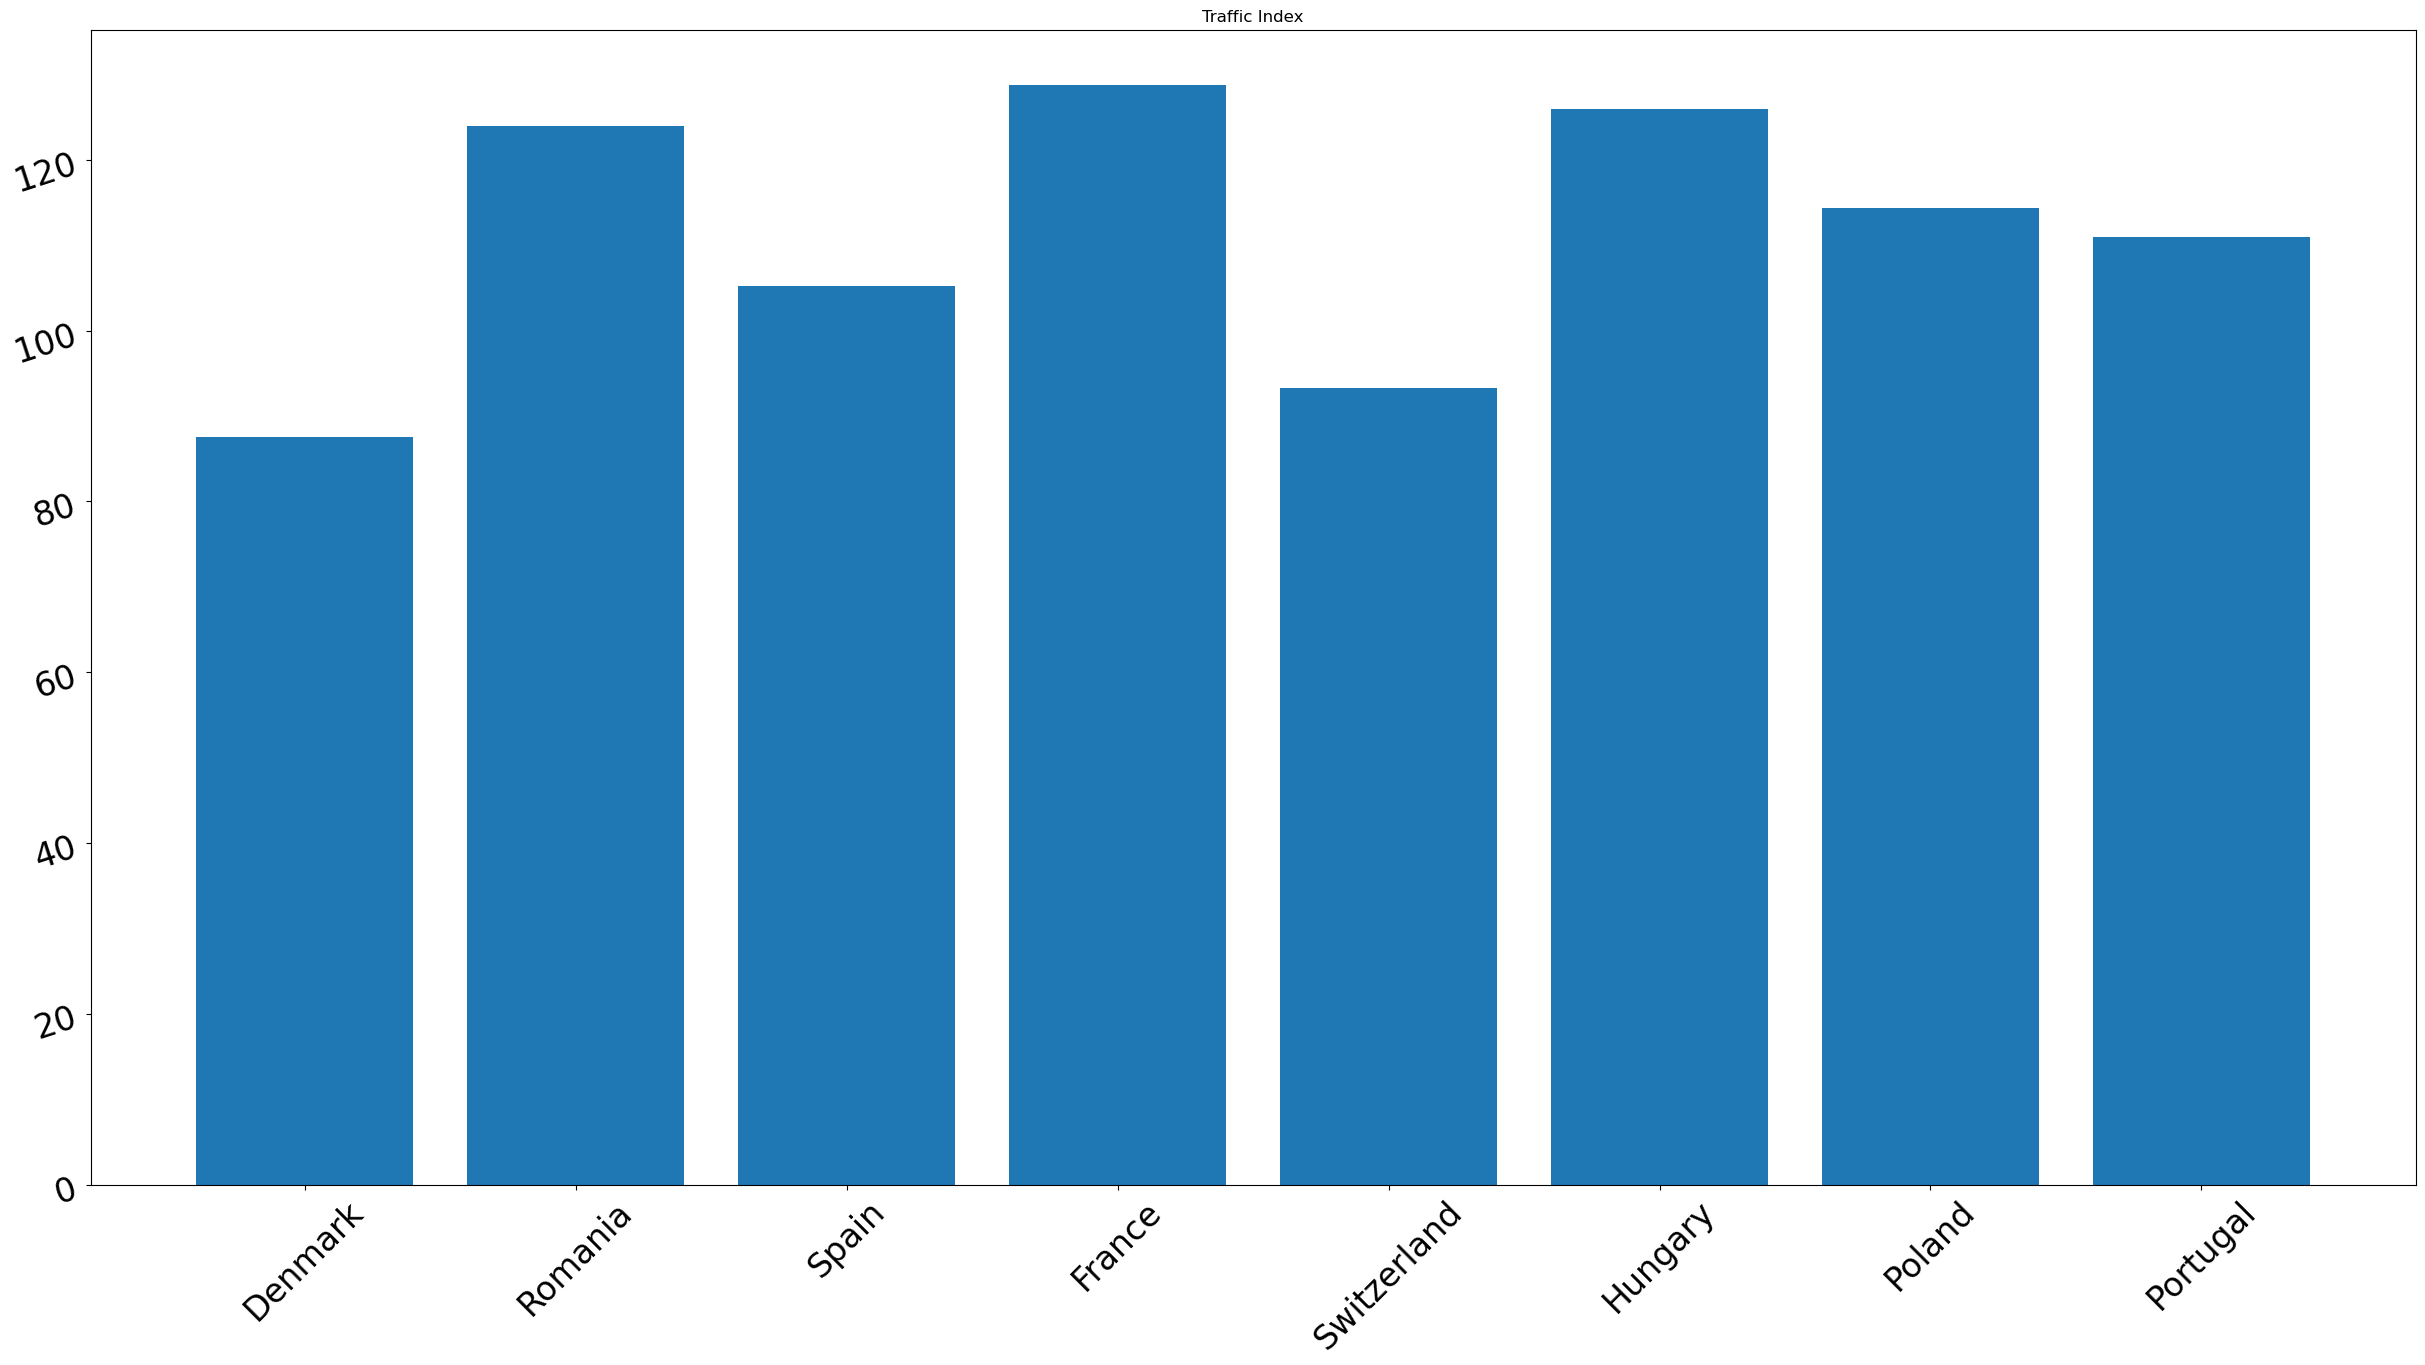

In [35]:
import matplotlib.pyplot as plt
    
plt.figure(figsize = (30,15))
plt.bar(final_df["Country"], final_df["Traffic Index"])
plt.xticks(fontsize = 24, rotation = 45)
plt.yticks(fontsize = 24, rotation = 18)
plt.title("Traffic Index")
plt.savefig("Traffic Index.png")
plt.show()


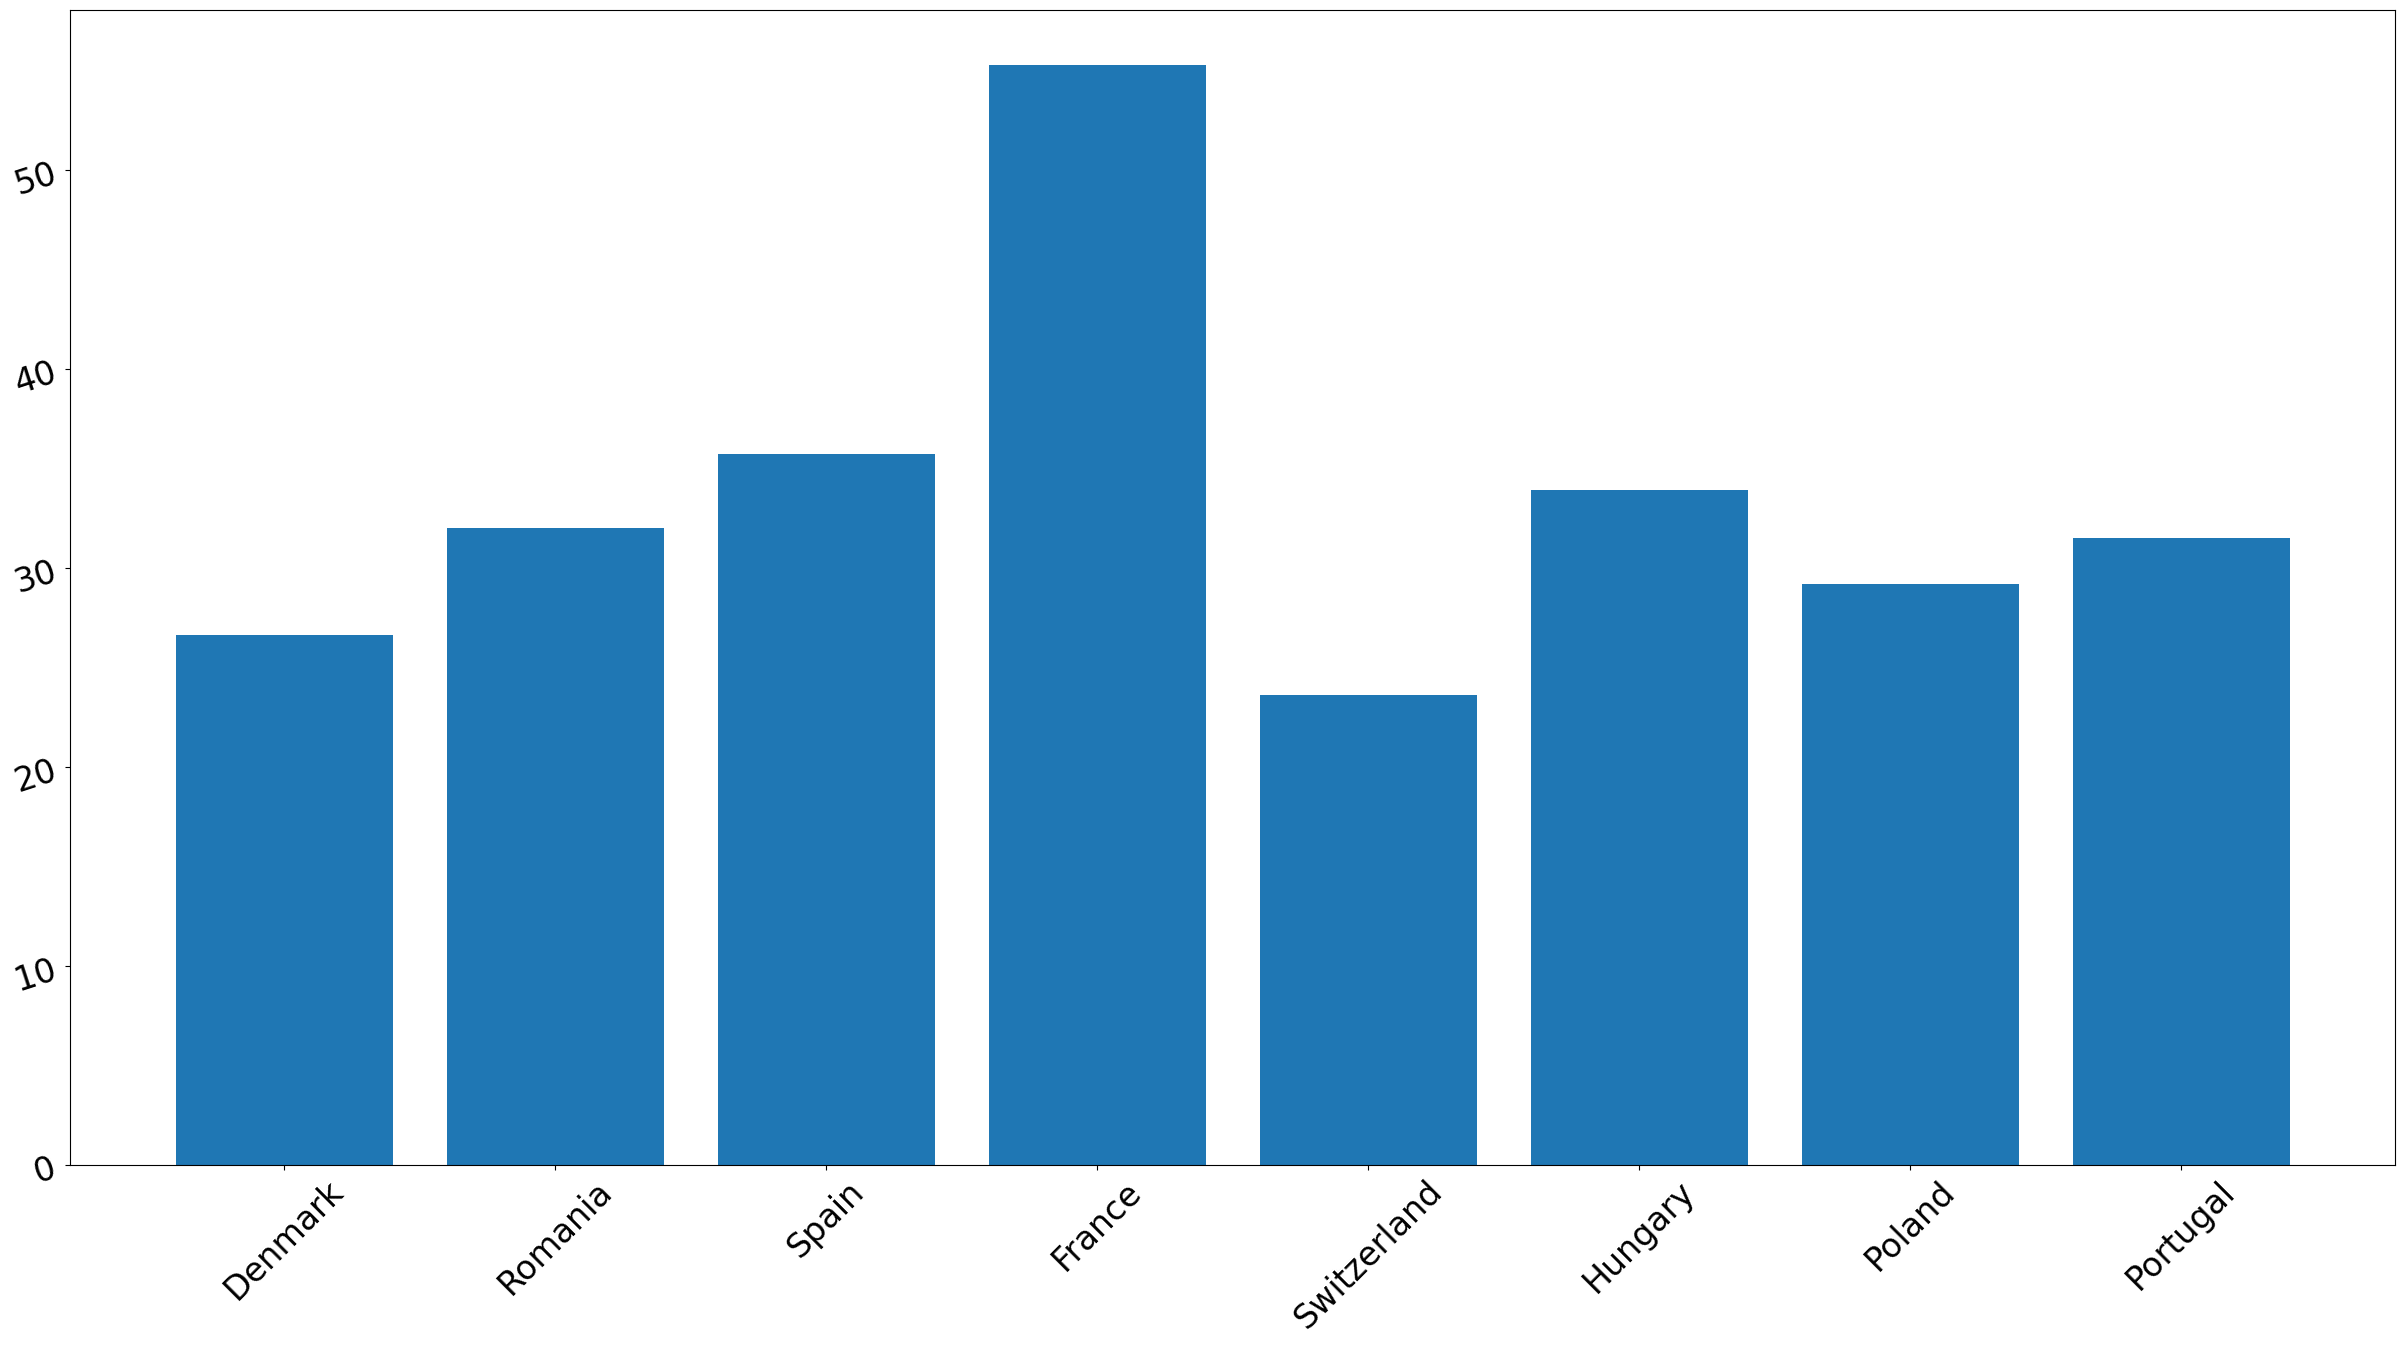

In [34]:
plt.figure(figsize = (30,15))
plt.bar(final_df["Country"], final_df["Crime Index"])
plt.xticks(fontsize = 24, rotation = 45)
plt.yticks(fontsize = 24, rotation = 18)
plt.savefig("Crime Index")
plt.show()


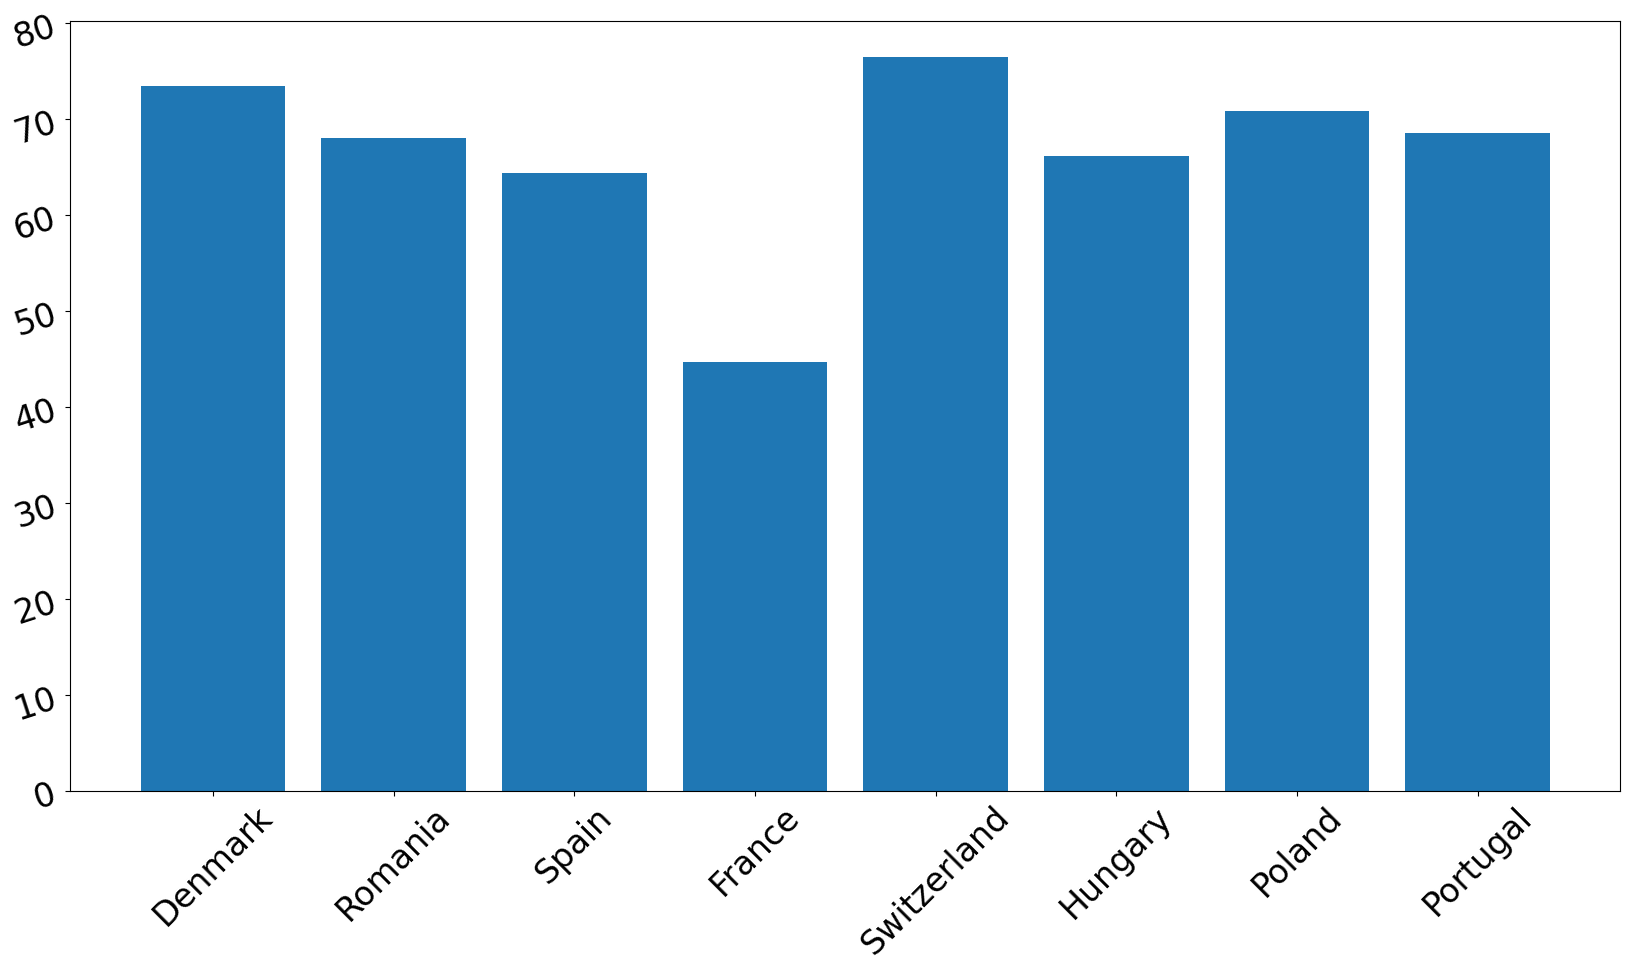

In [33]:
plt.figure(figsize = (20,10))
plt.bar(final_df["Country"], final_df["Safety Index"])
plt.xticks(fontsize = 24, rotation = 45)
plt.yticks(fontsize = 24, rotation = 18)
plt.savefig("Safety Index")
plt.show()


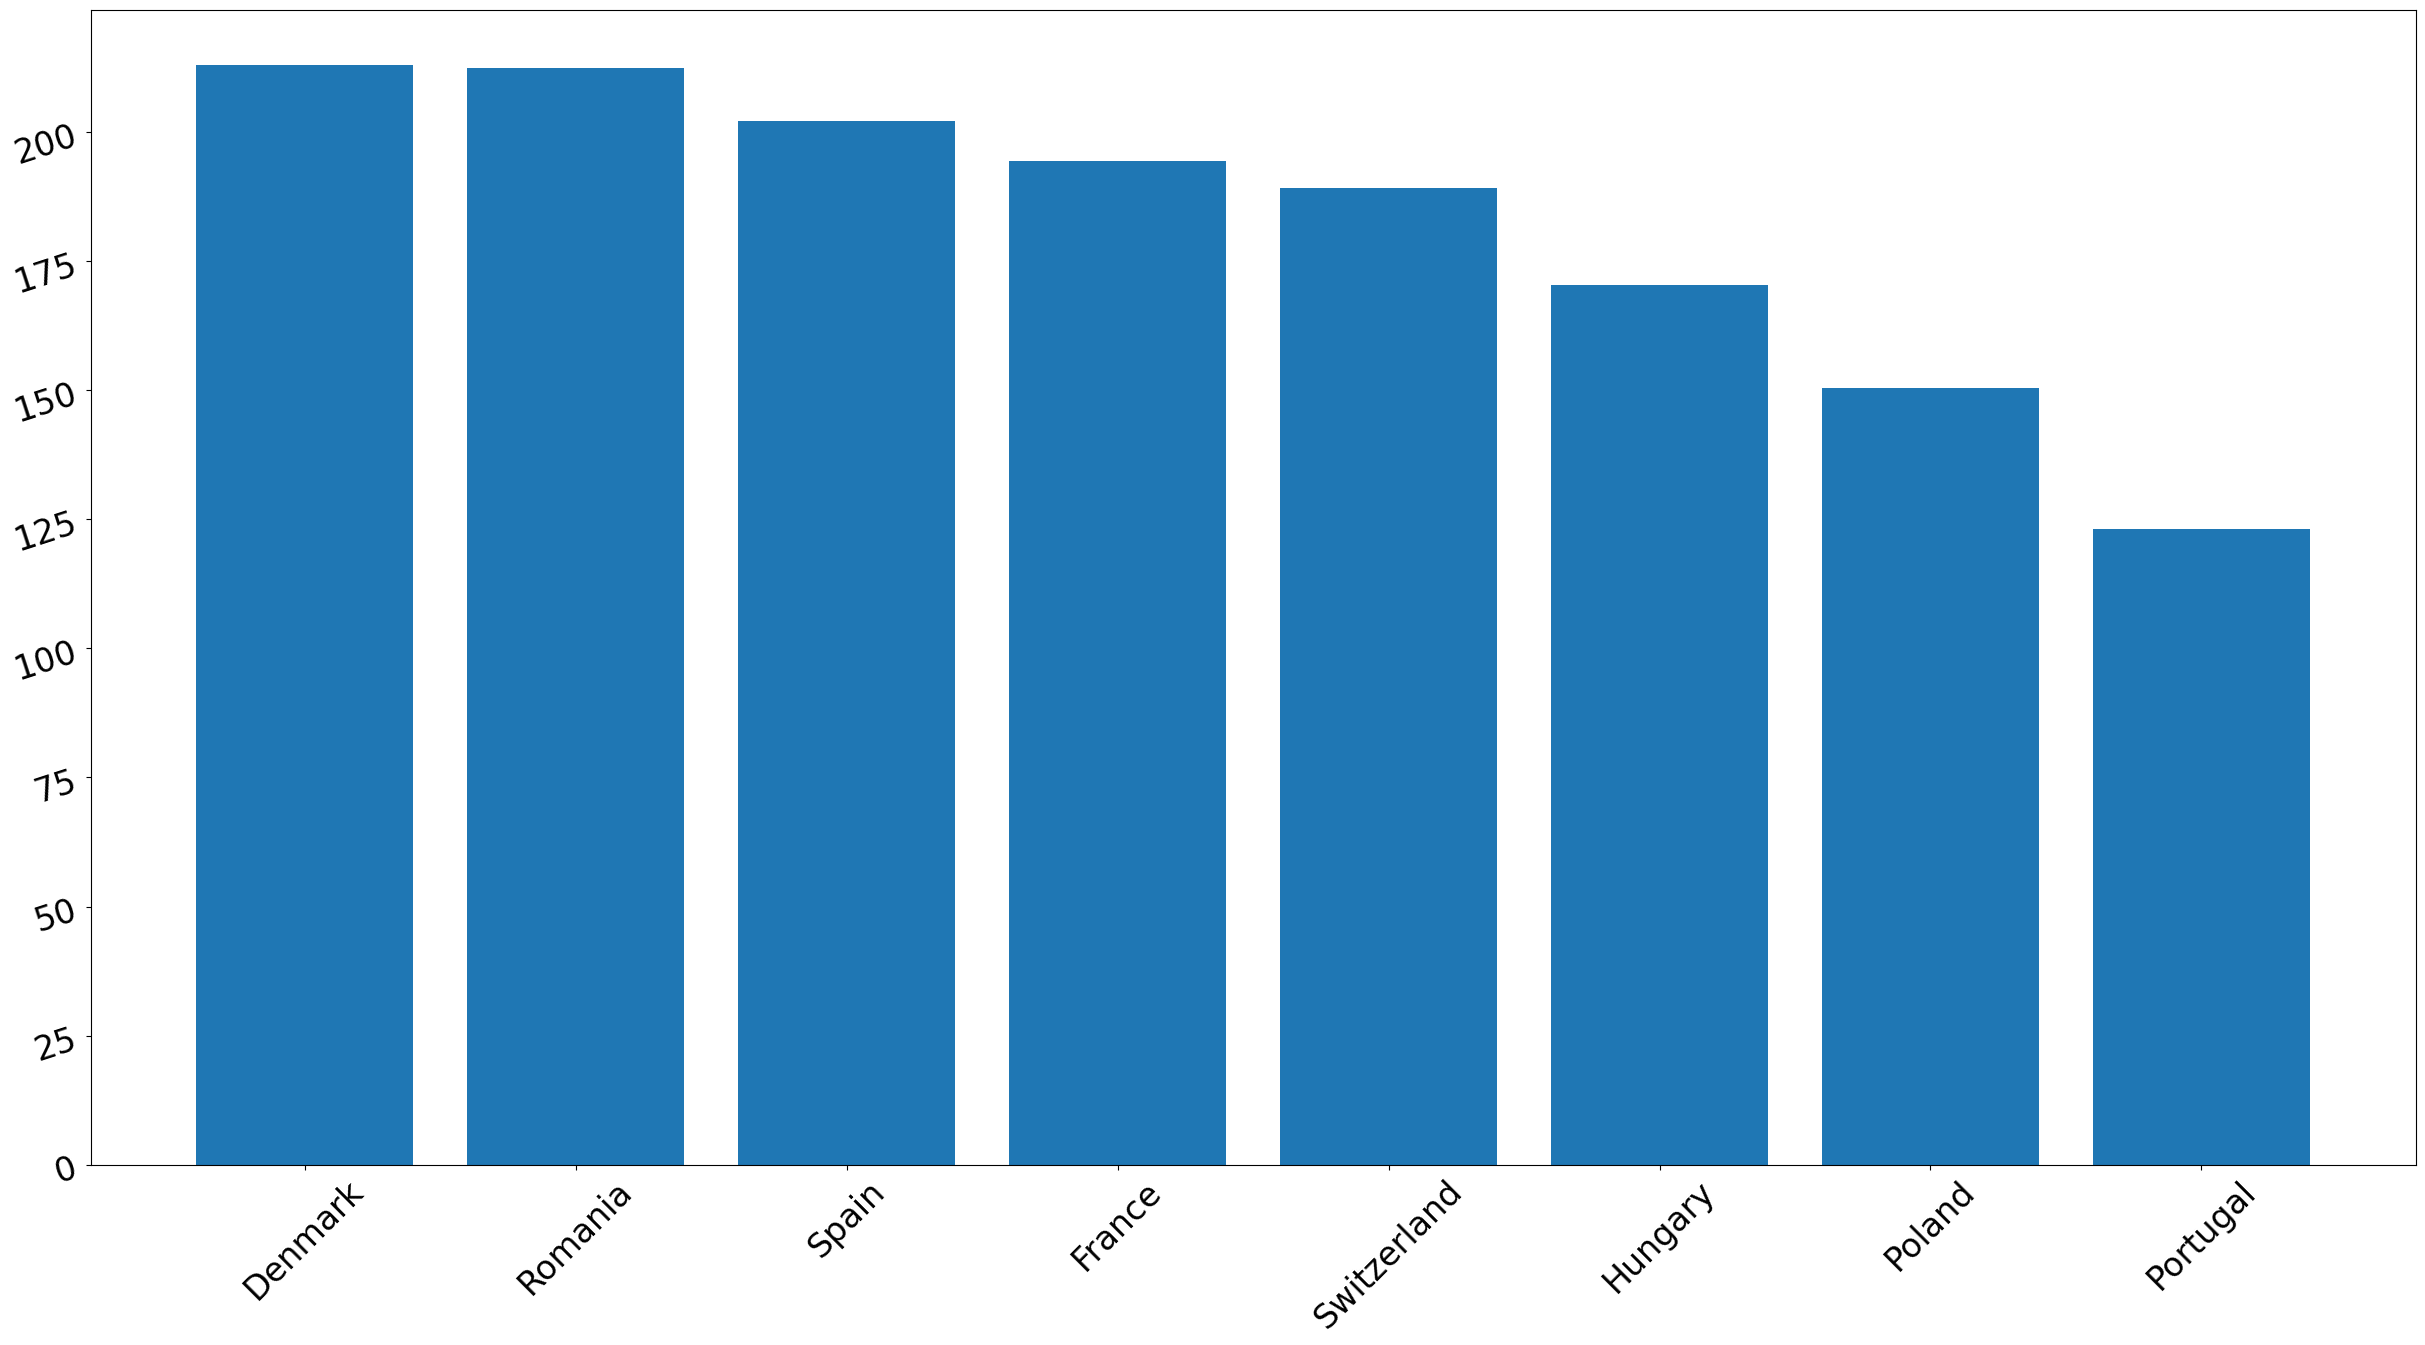

In [32]:
plt.figure(figsize = (30,15))
plt.bar(final_df["Country"], final_df["Internet Speed"])
plt.xticks(fontsize = 24, rotation = 45)
plt.yticks(fontsize = 24, rotation = 18)
plt.savefig("Internet Speed")
plt.show()


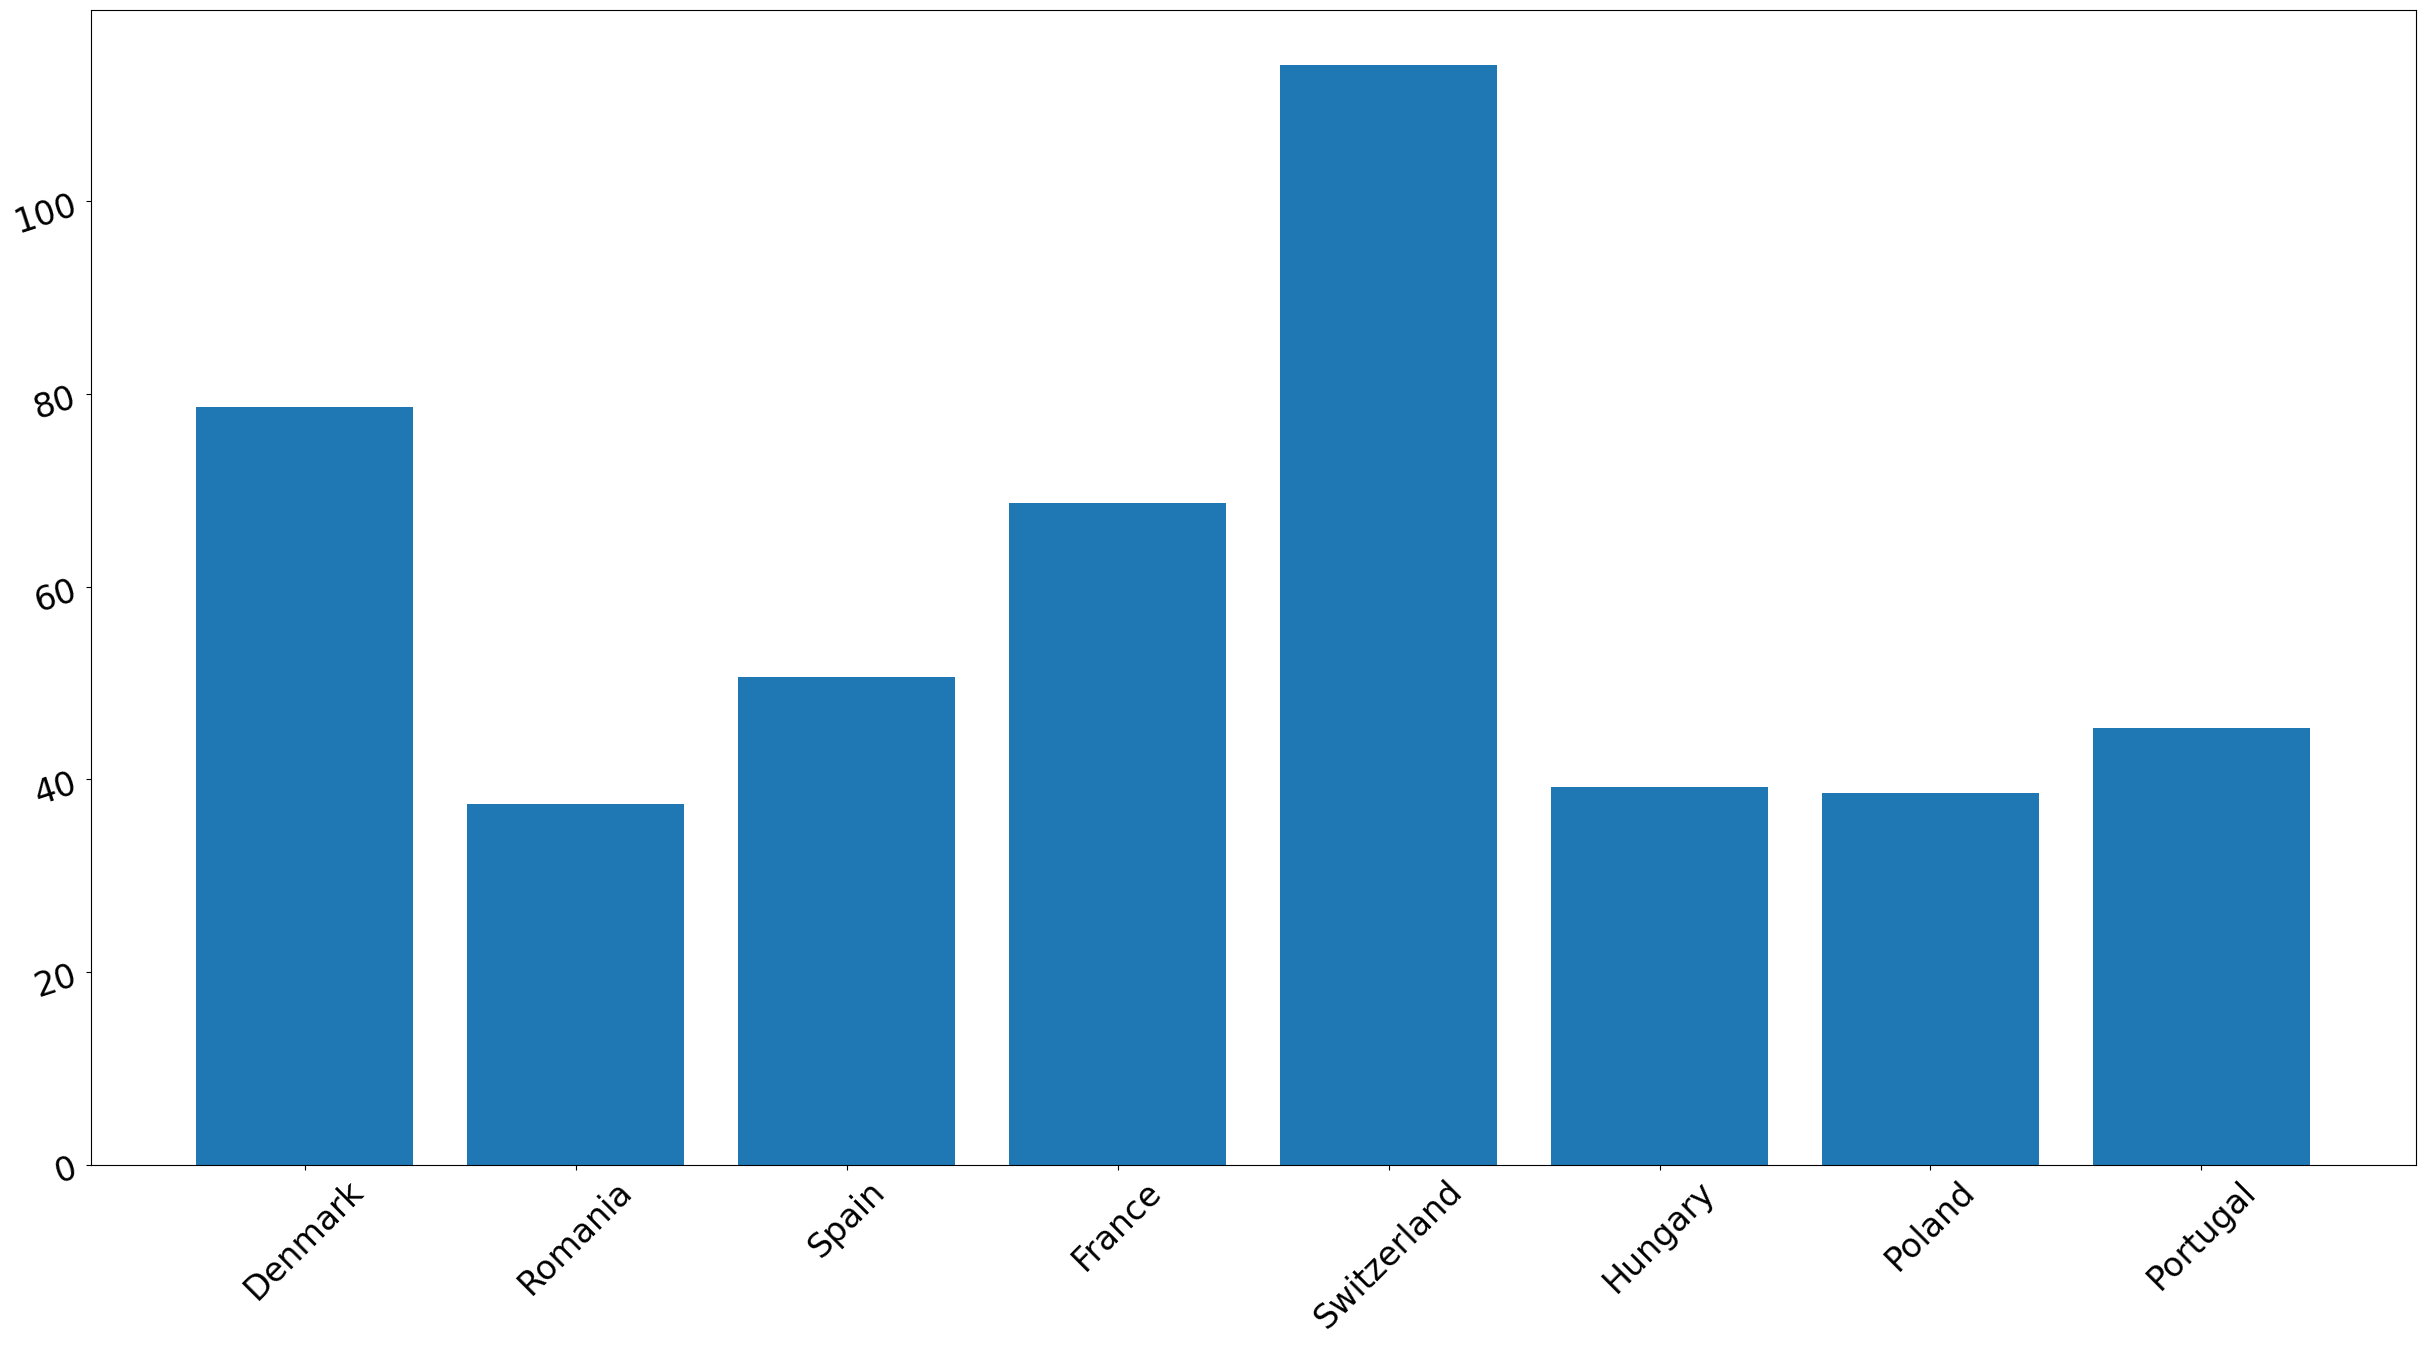

In [31]:
plt.figure(figsize = (30,15))
plt.bar(final_df["Country"], final_df["Cost of Living Index"])
plt.xticks(fontsize = 24, rotation = 45)
plt.yticks(fontsize = 24, rotation = 18)
plt.savefig("Cost of Living Index")
plt.show()


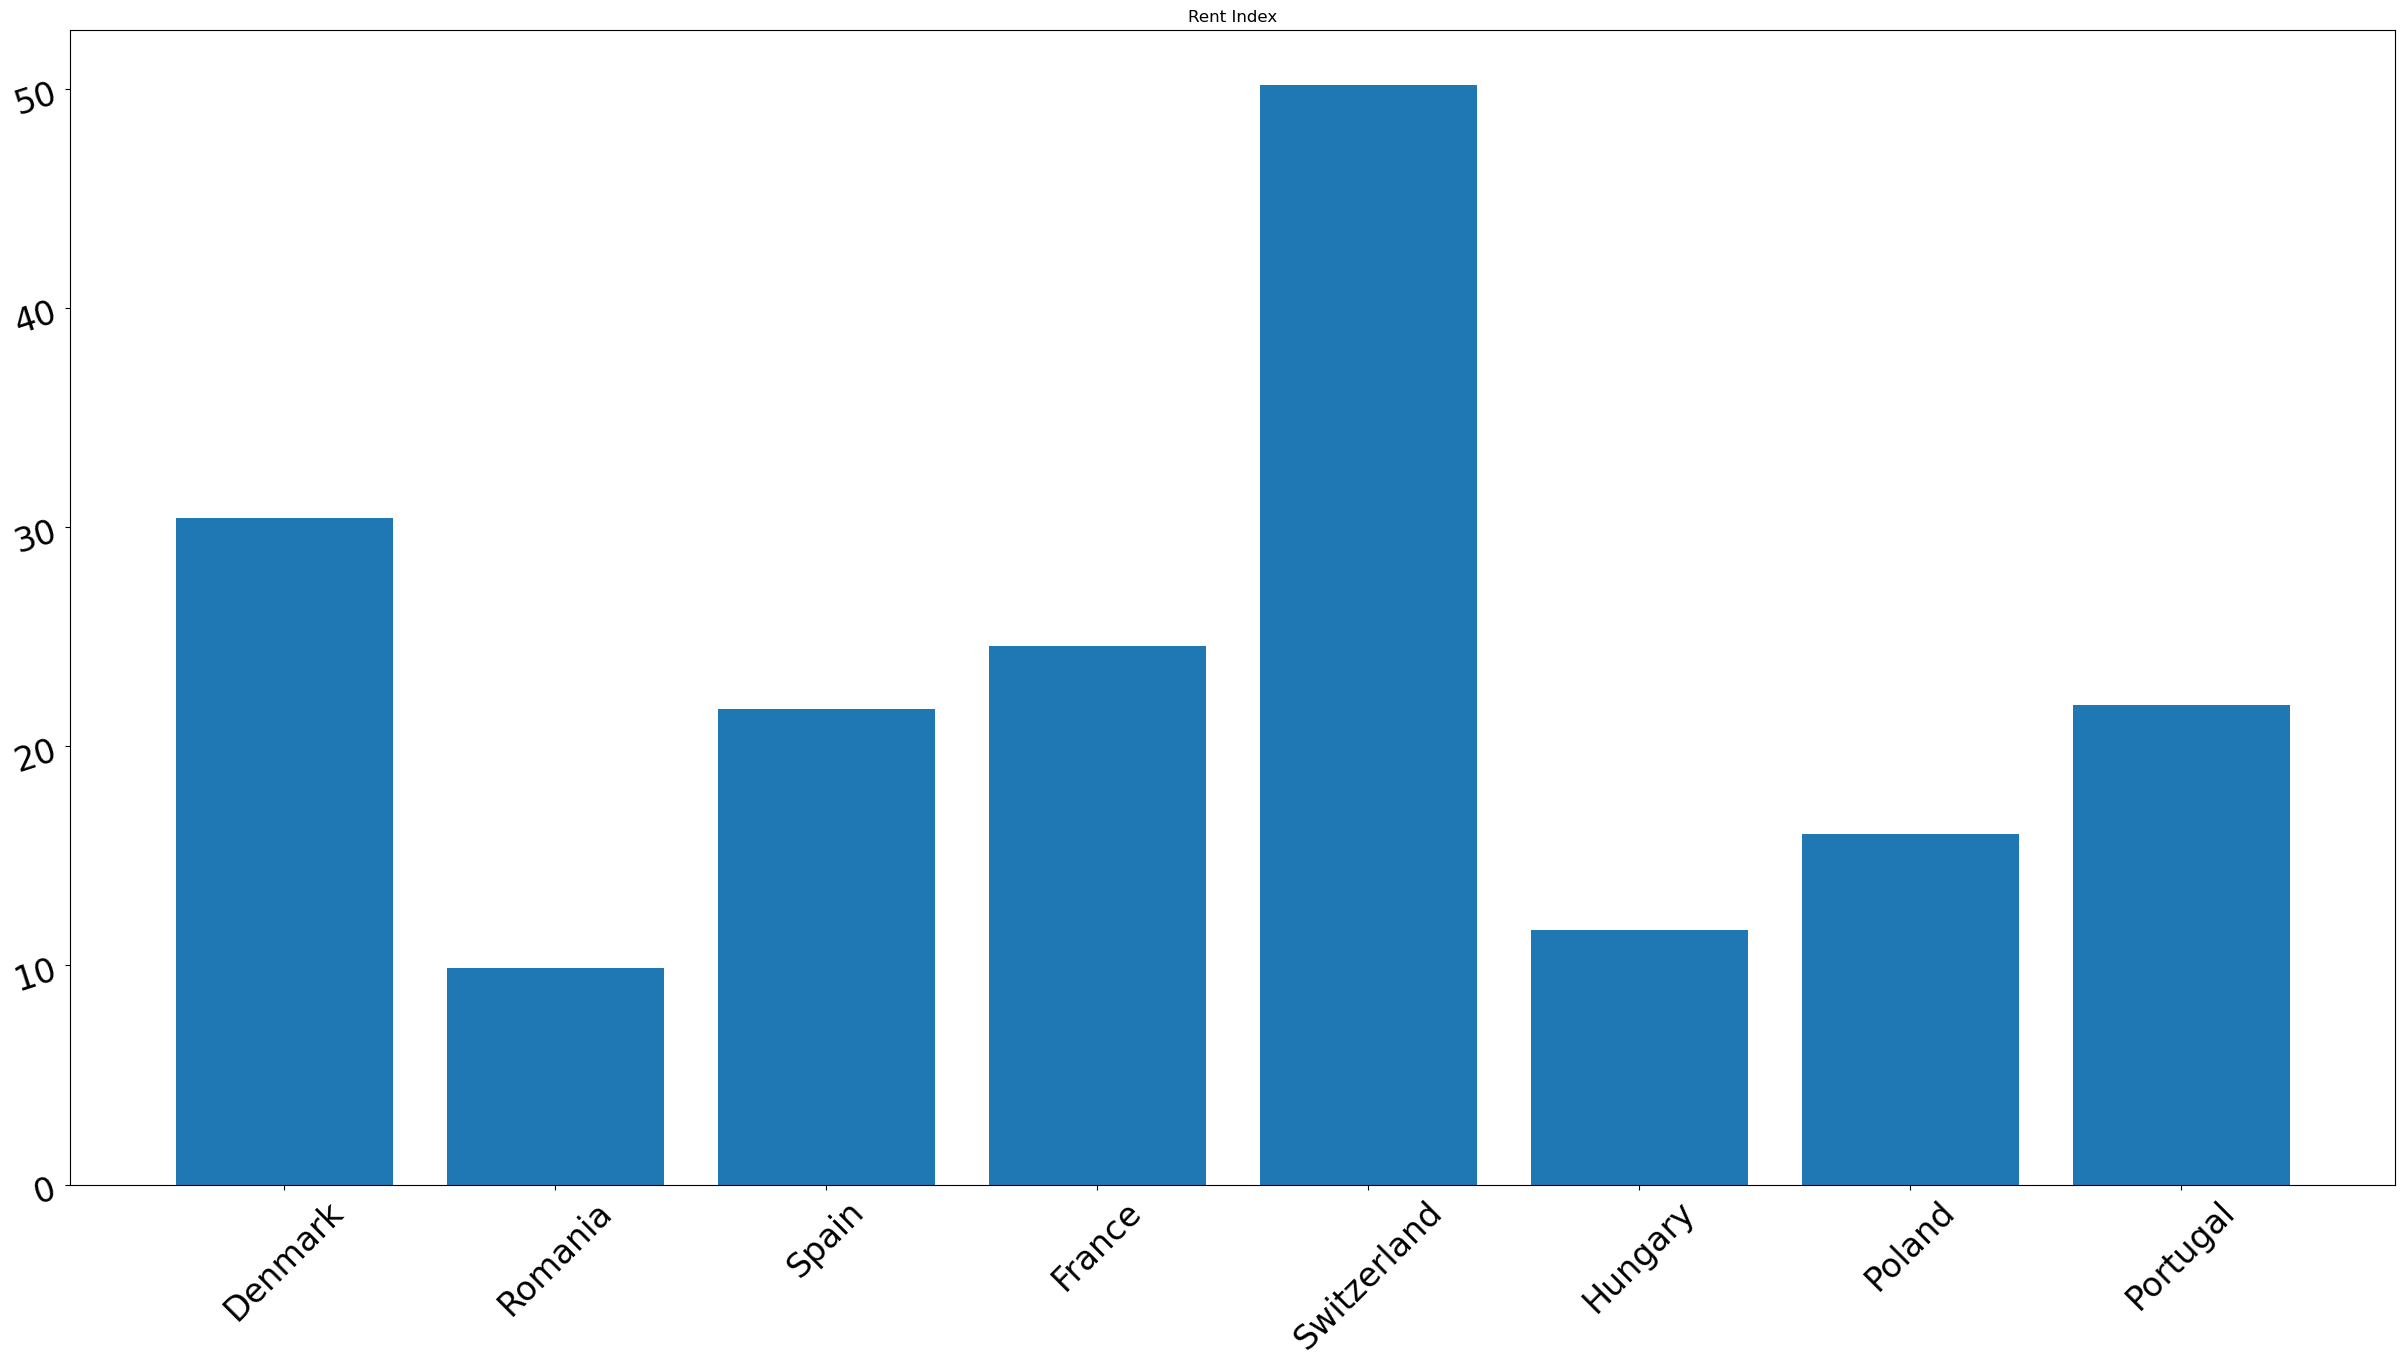

In [30]:
plt.figure(figsize = (30,15))
plt.bar(final_df["Country"], final_df["Rent Index"])
plt.xticks(fontsize = 24, rotation = 45)
plt.yticks(fontsize = 24, rotation = 18)
plt.savefig("rent_index.png")
plt.show()
